<a href="https://colab.research.google.com/github/CodeDiary18/Finance-Data-Analysis/blob/main/KNN%20%EC%B5%9C%EA%B7%BC%EC%A0%91%20%EC%9D%B4%EC%9B%83%20%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-최근접 이웃 알고리즘을 활용한 투자 전략

K-최근접 이웃(k-nearest neighbor, KNN) : 알고리즘은 다양한 레이블의 데이터에서 자신과 가까운 데이터를 찾아서 자신의 레이블(y값, 예측값)을 결정하는 알고리즘

## 데이터 로드

In [1]:
!pip install -U finance-datareader

In [2]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

파이낸스데이터리더를 통해서 S&P 500 지수를 추종하는 ETFs인 SPY를 사용했고 기간은 2012년 1월 1일부터 2017년 1월 1일까지로 설정

In [3]:
df = fdr.DataReader('SPY', '2012-01-01', '2017-01-01')
df = df.dropna()
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2012-01-03,127.50,127.76,128.38,127.43,193700000.0,0.0159
2012-01-04,127.70,127.20,127.81,126.71,127190000.0,0.0016
2012-01-05,128.04,127.01,128.23,126.43,173890000.0,0.0027
2012-01-06,127.71,128.20,128.22,127.29,148050000.0,-0.0026
2012-01-09,128.02,128.00,128.18,127.41,99530000.0,0.0024


필요한 열만 골라서 tmp_df에 저장합니다. tmp는 temporary의 약자로 관례적으로 데이터프레임을 복사할 때는 .copy()로 복사

In [4]:
tmp_df = df[['Open','High','Low','Close']].copy()
tmp_df.head(10)

,Open,High,Low,Close
Date,,,,
2012-01-03,127.76,128.38,127.43,127.50
2012-01-04,127.20,127.81,126.71,127.70
2012-01-05,127.01,128.23,126.43,128.04
2012-01-06,128.20,128.22,127.29,127.71
2012-01-09,128.00,128.18,127.41,128.02
2012-01-10,129.39,129.65,128.95,129.13
2012-01-11,128.73,129.37,128.52,129.20
2012-01-12,129.57,129.70,128.54,129.51
2012-01-13,128.64,129.05,127.72,128.84


## X와 y데이터 가공

분석에 필요한 시가(open)과 종가(close)의 차이를 나타내는 'Open-Close' 데이터와 고가(high)와 저가(low)의 차이를 나타내는 'High-Low' 데이터 생성  

주가의 오름up과 내림down을 정의하는 레이블인 Y를 만드는데 단순하게 다음날의 종가인 tmp_df['Close'].shift(-1)가 다음날의 시가인 tmp_df['Open'].shift(-1)보다 크다면 1, 그 반대라면 -1로 지정  

즉, 예측해야 하는 것은 다음날의 시가 대비 다음날의 종가므로, 현재의 시가 대비 다음날 종가가 높다면 1, 낮다면 -1로 설정  

In [5]:
tmp_df['Open-Close'] = tmp_df['Open'] - tmp_df['Close'] # 시가 - 종가
tmp_df['High-Low'] = tmp_df['High'] - tmp_df['Low'] # 고가 - 저가
tmp_df = tmp_df.dropna()
X = tmp_df[['Open-Close','High-Low']]
Y = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1), 1, -1)

많은 경우, 일별 예측에서 오늘의 종가 대비 내일의 종가가 높다면 오른다고 정의  
하지만 오늘의 종가가 이미 나온 시점에서 매수 전략을 실행하기가 매우 어렵기 때문에 다음날 시가에 살 수 있도록 다음날의 종가가 다음날의 시가보다 높다면 '오른다'고 정의한 것  

바로 이렇게 만들어진 레이블 변수가 전체적인 학습을 '지도'함.  
다음날의 종가를 미리 알 수 없지만, 일정한 패턴이 존재한다면 (혹은 과거 패턴이 미래에도 유지된다는 정상성 가정이 맞는다면) 이런 훈련을 통해서 패턴을 찾아낼 수 있음

In [6]:
X.head()

,Open-Close,High-Low
Date,,
2012-01-03,0.26,0.95
2012-01-04,-0.50,1.10
2012-01-05,-1.03,1.80
2012-01-06,0.49,0.93
2012-01-09,-0.02,0.77


In [7]:
Y[:5]

array([ 1,  1, -1,  1, -1])

## 훈련 데이터와 테스트 데이터를 7:3 비율로 분리

- 시계열 분석에서는 순서를 섞으면 안 됨  
- 데이터를 7:3 비율로 훈련 데이터와 테스트 데이터로 나눔

In [8]:
split_ratio = 0.7
split = int(split_ratio* len(tmp_df))
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

k의 값을 1에서 15까지 전부 시도를 해보면서 훈련 데이터와 테스트 데이터에 대한 정확도를 전부 측정해봅니다.

1. 우선 모델을 선언합니다.  
2. 모델.fit(훈련 데이터, 훈련 데이터에 대한 레이블)  
3. 예측값 =모델.predict(테스트 데이터)  
4. 테스트 데이터에 대한 예측값과 테스트 데이터에 대한 레이블로 테스트 성능 측정

In [9]:
#for 반복문을 통해 1~14까지의 k값을 가진 모델을 만들어 본다
train_acc = []
test_acc = []

for n in range(1,15):
    # k값을 1부터 14까지에 대해서 전부 수행
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)

    # fit은 KNN이 훈련 데이터에 대해서 학습
    clf.fit(X_train, Y_train)

    # predict은 학습된 모델에 X_test를 넣었을 때의 레이블. 즉, 입력된 데이터가 1인지, -1인지 예측
    prediction = clf.predict(X_test)

    # score는 정확도를 측정
    train_acc.append(clf.score(X_train, Y_train))
    test_acc.append((prediction==Y_test).mean())

In [10]:
prediction[:5]

array([ 1, -1, -1, -1,  1])

In [11]:
test_acc

[0.5634920634920635,
 0.5343915343915344,
 0.5502645502645502,
 0.5370370370370371,
 0.5582010582010583,
 0.5661375661375662,
 0.5793650793650794,
 0.5714285714285714,
 0.5634920634920635,
 0.5529100529100529,
 0.544973544973545,
 0.5396825396825397,
 0.5476190476190477,
 0.5317460317460317]

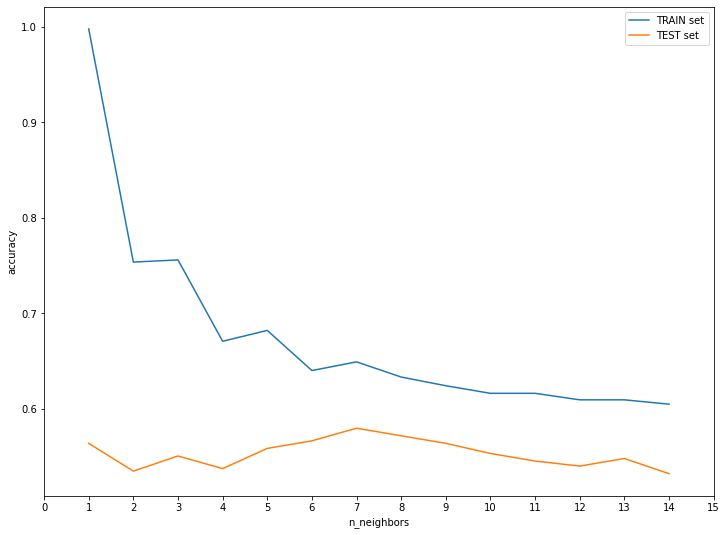

In [12]:
# 훈련/테스트 결과를 그래프로 시각화
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()

- K가 1일 때는 훈련 데이터가 모든 패턴을 외워버려서 100%의 정확도 나옴
- 그런데 성능을 실제로 측정하는 것 테스트 데이터이므로 사실 테스트 데이터의 정확도가 높은 것이 중요
- 훈련 데이터에 대해서만 정확도가 높고, 테스트 데이터에 대해서는 정확도가 낮다면 머신 러닝 용어로 과적합(Overfitting) 되었다고 하며, 이것은 원하는 결과 X  

- 그래프를 보면 테스트 데이터에서는 k=7일때가 성능이 가장 좋음

In [13]:
knn = KNeighborsClassifier(n_neighbors = 7)

knn.fit(X_train,Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('훈련 정확도 : %.2f' % accuracy_train)
print('테스트 정확도 : %.2f' % accuracy_test)

훈련 정확도 : 0.65
테스트 정확도 : 0.58


# 클러스터링 알고리즘을 활용한 종목 분류

In [14]:
from sklearn.preprocessing import Normalizer
import FinanceDataReader as fdr
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [15]:
#Wikipedia에서 S&P500에 포함된 회사들의 리스트를 가져옴
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].tolist()  #TICKER명만 리스트로 만듬
security = data_table[0]['Security'].tolist() #Ticker명에 해당하는 회사 전체 이름을 리스트로 가져옴
sector = data_table[0]['GICS Sector'].tolist()

tickers = tickers[0:60] #이해를 돕기위해 적은 양의 데이터만 사용함
security = security[0:60]
sector = sector[0:60]

prices_list = []

In [16]:
#리스트 길이가 같은지 확인
print(len(tickers))
print(len(security))
print(len(sector))

60
60
60


In [17]:
#tickers

In [18]:
#security

In [19]:
#sector

In [20]:
fdr.DataReader('MMM', '01/01/2017', '02/28/2020')

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,178.05,178.83,180.00,177.22,2510000.0,-0.0029
2017-01-04,178.32,178.03,178.90,177.61,1540000.0,0.0015
2017-01-05,177.71,178.26,179.14,176.89,1450000.0,-0.0034
2017-01-06,178.23,177.29,178.60,175.80,1630000.0,0.0029
2017-01-09,177.27,178.37,178.38,177.20,1620000.0,-0.0054
...,...,...,...,...,...,...
2020-02-24,152.55,154.45,154.71,152.22,3640000.0,-0.0279
2020-02-25,146.85,153.31,153.44,145.97,5260000.0,-0.0374
2020-02-26,148.96,149.57,151.82,148.09,5160000.0,0.0144


In [21]:
#데이터 불러오기. 2017년1월1일 부터 2020년 2월 28일까지의 데이터.
for ticker in tickers:
    try:
        prices = fdr.DataReader(ticker, '01/01/2017', '02/28/2020')['Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)

prices_df.sort_index(inplace=True)

prices_df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AAPL,AMAT,APTV,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,BKR,BLL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,178.05,39.05,62.41,112.36,116.46,36.64,103.48,11.43,170.60,11.66,34.88,46.49,143.40,67.57,88.00,88.05,110.58,96.96,64.70,37.93,74.17,808.0,786.1,67.63,753.67,NaN,52.38,46.30,62.76,75.35,65.12,106.15,72.25,111.85,82.61,49.22,150.73,33.72,72.50,93.35,143.24,112.08,47.50,63.78,29.04,31.94,56.57,46.19,97.06,52.24,94.12,43.02,74.55,76.18,103.50,791.46,176.62,70.14,45.30,37.88
2017-01-04,178.32,39.36,63.29,115.74,116.74,37.36,104.14,11.43,172.00,11.56,35.20,47.10,144.65,68.33,89.18,90.70,113.38,97.77,65.93,38.16,74.37,807.8,786.9,67.85,757.18,NaN,52.44,46.70,62.85,76.26,65.97,106.34,72.81,115.20,84.66,49.81,152.87,33.97,72.36,94.44,143.05,113.31,47.92,63.59,29.00,32.24,58.66,46.11,101.73,52.90,95.09,42.77,74.97,77.52,103.66,793.04,177.35,72.14,45.10,38.45
2017-01-05,177.71,39.70,63.77,114.81,114.99,37.94,105.91,11.24,171.88,11.41,34.98,46.54,143.22,69.55,87.76,90.39,112.97,94.82,66.29,38.11,74.03,813.0,794.0,67.93,780.45,NaN,52.70,45.89,63.19,75.32,65.60,105.97,72.93,113.74,83.68,49.18,152.98,33.78,71.32,94.71,144.57,113.48,47.70,63.25,29.15,32.10,58.30,45.77,101.94,53.02,95.13,42.65,74.60,76.93,103.04,792.00,178.43,71.43,44.83,38.43
2017-01-06,178.23,40.78,63.79,115.42,116.30,37.91,108.30,11.32,169.63,11.82,35.09,47.99,144.36,69.79,86.98,90.81,112.21,94.08,65.89,37.80,74.15,825.2,806.2,68.23,795.99,NaN,53.10,46.21,63.14,75.47,66.81,105.27,72.84,115.66,84.80,50.07,156.78,34.04,71.60,93.95,144.35,114.35,47.72,63.12,29.48,32.04,57.94,44.72,101.28,53.14,95.98,41.32,74.17,79.30,103.11,792.91,180.00,72.40,44.55,38.60
2017-01-09,177.27,40.74,64.21,117.11,115.00,37.70,108.57,11.49,169.53,11.53,34.76,48.14,146.31,70.00,87.47,90.48,111.05,94.79,65.42,37.28,73.09,827.2,806.7,67.95,796.92,NaN,51.99,47.08,62.31,75.86,66.38,105.02,71.35,115.20,85.48,49.63,158.84,33.69,71.94,94.29,142.79,113.40,47.40,62.36,29.75,32.78,57.01,44.75,99.52,52.40,94.11,40.80,73.21,79.59,102.47,790.34,177.22,72.56,44.05,37.99


In [22]:
temp_series = prices_df.isnull().sum()
#temp_series

In [23]:
temp_series[temp_series > 0]

AMCR    613
dtype: int64

In [24]:
del prices_df['AMCR']
#prices_df.isnull().sum()

**pct_change()**
- 변화율을 구하는 함수. 즉, 수익률을 구함 
- 데이터프레임으로부터 수익율을 구한 뒤에 전치(transpose)를 함

In [25]:
df = prices_df.pct_change().iloc[1:].T
df.head()

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28
MMM,0.001516,-0.003421,0.002926,-0.005386,-0.003892,0.007419,-0.002530,-0.000282,-0.000733,0.006939,0.001064,-0.001063,0.000112,-0.014229,0.004319,0.000509,0.003733,-0.011607,-0.003420,0.002002,-0.005652,0.004937,0.000343,0.003769,0.007453,0.006269,0.004602,0.011285,0.003204,0.000551,0.009411,-0.002508,0.002296,0.014561,0.006181,0.001175,-0.002668,-0.002996,0.018836,0.000158,...,0.020292,-0.008611,0.000953,-0.004031,0.015346,0.003156,-0.004029,0.002493,0.002487,-0.008767,0.006842,0.001878,-0.010808,-0.007581,-0.001629,0.002307,-0.014145,-0.057223,-0.021621,0.003148,-0.023691,-0.013047,0.004151,0.032371,0.003450,-0.017251,0.000437,0.014362,0.008310,-0.024664,0.007824,-0.013229,0.002895,-0.004895,-0.010280,-0.027911,-0.037365,0.014368,0.008056,-0.006127
ABT,0.007939,0.008638,0.027204,-0.000981,0.013500,-0.005086,-0.008763,0.005157,-0.000733,-0.003423,-0.008832,0.001485,-0.002966,-0.000744,0.000000,0.016125,0.000977,0.000244,0.018532,0.013407,0.009922,0.000702,-0.008181,0.010841,-0.011425,0.003302,0.004701,0.011231,0.009949,0.008018,0.004545,0.011086,0.007160,0.000000,0.008665,0.006167,-0.004816,-0.008359,0.011313,0.002193,...,0.001036,-0.012191,0.005239,-0.005559,0.004076,0.002668,-0.012494,-0.002812,0.007284,0.019128,0.010300,0.008156,0.008202,0.023738,-0.012301,-0.003637,-0.008960,-0.000558,-0.004467,0.000224,-0.022656,-0.000918,0.013439,0.015074,-0.001005,-0.017883,0.004894,0.009853,-0.004262,-0.001239,0.011051,-0.008700,0.005401,-0.010072,-0.011418,-0.032247,-0.041356,0.002835,-0.026672,-0.027276
ABBV,0.014100,0.007584,0.000314,0.006584,-0.002180,-0.045731,0.002290,0.011586,-0.002097,-0.003233,-0.004541,-0.003747,-0.003107,-0.006234,0.013206,-0.001792,-0.020728,0.007167,0.011253,-0.003600,0.000000,-0.003613,-0.000330,-0.001484,-0.000661,0.005288,-0.006903,0.001490,0.005123,0.013647,-0.002758,0.004717,0.000971,-0.007601,0.009452,0.002422,0.002094,-0.006107,0.016009,0.006685,...,0.011407,-0.009492,0.007892,-0.005705,0.007087,0.007708,-0.012748,-0.006063,-0.003615,0.012018,0.000000,-0.014116,-0.000114,-0.008865,-0.022245,-0.020288,0.005746,-0.002975,-0.006804,-0.017067,-0.009293,0.015799,0.025030,0.026908,0.006349,0.058614,0.026655,0.013193,0.018646,-0.024951,-0.013634,-0.004678,0.005662,0.000956,0.007747,-0.019166,-0.042517,-0.008634,-0.033820,0.003395
ABMD,0.030082,-0.008035,0.005313,0.014642,-0.041585,-0.008642,0.009886,0.029367,-0.014265,-0.006578,-0.009358,-0.003297,-0.002414,0.006543,0.022440,-0.076032,0.026016,-0.024805,0.002073,-0.007333,-0.014111,0.008261,0.052782,-0.005068,-0.011006,-0.002575,0.001752,-0.011598,0.014714,0.015235,0.032815,0.020306,0.010637,-0.006875,-0.000940,0.002139,0.006829,0.000254,0.028143,-0.010223,...,-0.010434,-0.011788,0.073253,0.007317,-0.009204,0.027478,0.029739,-0.110864,0.027543,0.030047,0.019784,-0.000882,0.047606,-0.028908,0.000217,-0.008023,-0.008362,0.030642,0.009839,-0.010590,-0.002997,-0.001825,0.026620,-0.000891,0.027683,-0.046426,-0.068643,0.009995,-0.050506,-0.012819,0.014684,0.010645,-0.006509,0.001072,-0.007972,-0.008696,-0.039264,-0.029660,-0.000779,-0.024096
ACN,0.002404,-0.014991,0.011392,-0.011178,0.000

In [26]:
test1 = df.index.to_list()

In [27]:
test1 == tickers

False

In [28]:
#회사명 리스트와 값의 리스트를 저장한다.
companies = list(df.index)
companies
movements = df.values
movements

array([[ 0.00151643, -0.00342082,  0.00292612, ...,  0.0143684 ,
         0.00805585, -0.0061268 ],
       [ 0.00793854,  0.00863821,  0.02720403, ...,  0.00283496,
        -0.02667158, -0.02727617],
       [ 0.0141003 ,  0.00758414,  0.00031363, ..., -0.00863422,
        -0.0338197 ,  0.00339499],
       ...,
       [ 0.0285144 , -0.00984197,  0.01357973, ..., -0.01382488,
        -0.03963618, -0.00521331],
       [-0.00441501, -0.0059867 , -0.00624582, ..., -0.0461869 ,
        -0.06137387, -0.03479304],
       [ 0.01504752, -0.00052016,  0.00442363, ...,  0.01529585,
        -0.04836791, -0.02152479]])

* Tip 1 : 군집을 하기 전에 전체 데이터에 대해서 값의 범위를 줄여주는 것이 군집 성능을 높일 수 있다. 값의 범위가 열에 따라서 너무 차이가 나면 군집 성능에 영향을 줄 수 있기 때문이다. 이를 값을 '스케일링' 한다고 한다.    
* Tip 2 : 사이킷런의 Normalizer의 fit_transform()을 사용하면 데이터프레임의 값의 범위를 한 번에 줄여줄 수 있으므로 클러스터링 알고리즘을 수행하기 전에 사용할 수 있다. Normalizer 외에도 값을 스케일링 할 수 있는 방법은 여러가지가 있다.

In [29]:
normalize = Normalizer()
array_norm = normalize.fit_transform(df)
df_norm = pd.DataFrame(array_norm, columns=df.columns)
final_df = df_norm.set_index(df.index)
final_df.head(10)

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28
MMM,0.003951,-0.008914,0.007625,-0.014035,-0.010143,0.019331,-0.006592,-0.000734,-0.001910,0.018081,0.002774,-0.002771,0.000292,-0.037077,0.011254,0.001327,0.009726,-0.030245,-0.008913,0.005217,-0.014727,0.012866,0.000893,0.009822,0.019422,0.016335,0.011992,0.029406,0.008349,0.001435,0.024523,-0.006535,0.005982,0.037942,0.016107,0.003062,-0.006952,-0.007807,0.049081,0.000412,...,0.052877,-0.022438,0.002482,-0.010504,0.039987,0.008223,-0.010498,0.006497,0.006481,-0.022844,0.017828,0.004895,-0.028163,-0.019755,-0.004245,0.006011,-0.036859,-0.149108,-0.056339,0.008203,-0.061732,-0.033997,0.010816,0.084351,0.008989,-0.044952,0.001139,0.037423,0.021654,-0.064269,0.020388,-0.034471,0.007544,-0.012756,-0.026787,-0.072728,-0.097363,0.037440,0.020992,-0.015965
ABT,0.023143,0.025183,0.079308,-0.002860,0.039357,-0.014827,-0.025548,0.015035,-0.002137,-0.009979,-0.025749,0.004330,-0.008647,-0.002168,0.000000,0.047010,0.002847,0.000711,0.054027,0.039085,0.028926,0.002046,-0.023851,0.031606,-0.033306,0.009626,0.013706,0.032741,0.029005,0.023376,0.013251,0.032319,0.020875,0.000000,0.025260,0.017980,-0.014040,-0.024369,0.032982,0.006395,...,0.003021,-0.035540,0.015274,-0.016207,0.011884,0.007778,-0.036425,-0.008197,0.021235,0.055763,0.030027,0.023777,0.023912,0.069203,-0.035862,-0.010603,-0.026122,-0.001627,-0.013024,0.000654,-0.066049,-0.002676,0.039179,0.043946,-0.002930,-0.052135,0.014266,0.028724,-0.012424,-0.003612,0.032217,-0.025362,0.015744,-0.029362,-0.033286,-0.094010,-0.120567,0.008265,-0.077756,-0.079519
ABBV,0.028591,0.015378,0.000636,0.013350,-0.004421,-0.092727,0.004643,0.023493,-0.004252,-0.006556,-0.009208,-0.007598,-0.006300,-0.012640,0.026777,-0.003634,-0.042029,0.014532,0.022817,-0.007300,0.000000,-0.007326,-0.000668,-0.003009,-0.001339,0.010721,-0.013998,0.003020,0.010388,0.027671,-0.005591,0.009564,0.001970,-0.015413,0.019166,0.004910,0.004245,-0.012384,0.032461,0.013554,...,0.023130,-0.019246,0.016002,-0.011567,0.014371,0.015629,-0.025849,-0.012294,-0.007330,0.024369,0.000000,-0.028622,-0.000230,-0.017974,-0.045105,-0.041138,0.011650,-0.006033,-0.013797,-0.034607,-0.018843,0.032034,0.050753,0.054561,0.012873,0.118850,0.054047,0.026750,0.037807,-0.050593,-0.027645,-0.009486,0.011480,0.001938,0.015708,-0.038862,-0.086209,-0.017507,-0.068575,0.006884
ABMD,0.039471,-0.010543,0.006972,0.019213,-0.054565,-0.011340,0.012972,0.038534,-0.018717,-0.008631,-0.012279,-0.004327,-0.003168,0.008585,0.029444,-0.099764,0.034136,-0.032547,0.002719,-0.009622,-0.018516,0.010840,0.069257,-0.006650,-0.014441,-0.003379,0.002299,-0.015218,0.019307,0.019990,0.043058,0.026645,0.013958,-0.009022,-0.001234,0.002806,0.008961,0.000334,0.036927,-0.013415,...,-0.013691,-0.015468,0.096117,0.009601,-0.012077,0.036055,0.039021,-0.145469,0.036140,0.039426,0.025959,-0.001157,0.062465,-0.037932,0.000285,-0.010528,-0.010972,0.040206,0.012910,-0.013896,-0.003933,-0.002395,0.034929,-0.001168,0.036324,-0.060917,-0.090068,0.013115,-0.066271,-0.016820,0.019268,0.013967,-0.008541,0.001407,-0.010461,-0.011411,-0.051520,-0.038918,-0.001022,-0.031617
ACN,0.007264,-0.045292,0.034420,-0.033773,0.001

In [30]:
#누락된 데이터가 없는지 확인
col_mask = df.isnull().any(axis=0)
row_mask = df.isnull().any(axis=1)
df.loc[row_mask, col_mask]

Date


In [31]:
df

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28
MMM,0.001516,-0.003421,0.002926,-0.005386,-0.003892,0.007419,-0.002530,-0.000282,-0.000733,0.006939,0.001064,-0.001063,0.000112,-0.014229,0.004319,0.000509,0.003733,-0.011607,-0.003420,0.002002,-0.005652,0.004937,0.000343,0.003769,0.007453,0.006269,0.004602,0.011285,0.003204,0.000551,0.009411,-0.002508,0.002296,0.014561,0.006181,0.001175,-0.002668,-0.002996,0.018836,0.000158,...,0.020292,-0.008611,0.000953,-0.004031,0.015346,0.003156,-0.004029,0.002493,0.002487,-0.008767,0.006842,0.001878,-0.010808,-0.007581,-0.001629,0.002307,-0.014145,-0.057223,-0.021621,0.003148,-0.023691,-0.013047,0.004151,0.032371,0.003450,-0.017251,0.000437,0.014362,0.008310,-0.024664,0.007824,-0.013229,0.002895,-0.004895,-0.010280,-0.027911,-0.037365,0.014368,0.008056,-0.006127
ABT,0.007939,0.008638,0.027204,-0.000981,0.013500,-0.005086,-0.008763,0.005157,-0.000733,-0.003423,-0.008832,0.001485,-0.002966,-0.000744,0.000000,0.016125,0.000977,0.000244,0.018532,0.013407,0.009922,0.000702,-0.008181,0.010841,-0.011425,0.003302,0.004701,0.011231,0.009949,0.008018,0.004545,0.011086,0.007160,0.000000,0.008665,0.006167,-0.004816,-0.008359,0.011313,0.002193,...,0.001036,-0.012191,0.005239,-0.005559,0.004076,0.002668,-0.012494,-0.002812,0.007284,0.019128,0.010300,0.008156,0.008202,0.023738,-0.012301,-0.003637,-0.008960,-0.000558,-0.004467,0.000224,-0.022656,-0.000918,0.013439,0.015074,-0.001005,-0.017883,0.004894,0.009853,-0.004262,-0.001239,0.011051,-0.008700,0.005401,-0.010072,-0.011418,-0.032247,-0.041356,0.002835,-0.026672,-0.027276
ABBV,0.014100,0.007584,0.000314,0.006584,-0.002180,-0.045731,0.002290,0.011586,-0.002097,-0.003233,-0.004541,-0.003747,-0.003107,-0.006234,0.013206,-0.001792,-0.020728,0.007167,0.011253,-0.003600,0.000000,-0.003613,-0.000330,-0.001484,-0.000661,0.005288,-0.006903,0.001490,0.005123,0.013647,-0.002758,0.004717,0.000971,-0.007601,0.009452,0.002422,0.002094,-0.006107,0.016009,0.006685,...,0.011407,-0.009492,0.007892,-0.005705,0.007087,0.007708,-0.012748,-0.006063,-0.003615,0.012018,0.000000,-0.014116,-0.000114,-0.008865,-0.022245,-0.020288,0.005746,-0.002975,-0.006804,-0.017067,-0.009293,0.015799,0.025030,0.026908,0.006349,0.058614,0.026655,0.013193,0.018646,-0.024951,-0.013634,-0.004678,0.005662,0.000956,0.007747,-0.019166,-0.042517,-0.008634,-0.033820,0.003395
ABMD,0.030082,-0.008035,0.005313,0.014642,-0.041585,-0.008642,0.009886,0.029367,-0.014265,-0.006578,-0.009358,-0.003297,-0.002414,0.006543,0.022440,-0.076032,0.026016,-0.024805,0.002073,-0.007333,-0.014111,0.008261,0.052782,-0.005068,-0.011006,-0.002575,0.001752,-0.011598,0.014714,0.015235,0.032815,0.020306,0.010637,-0.006875,-0.000940,0.002139,0.006829,0.000254,0.028143,-0.010223,...,-0.010434,-0.011788,0.073253,0.007317,-0.009204,0.027478,0.029739,-0.110864,0.027543,0.030047,0.019784,-0.000882,0.047606,-0.028908,0.000217,-0.008023,-0.008362,0.030642,0.009839,-0.010590,-0.002997,-0.001825,0.026620,-0.000891,0.027683,-0.046426,-0.068643,0.009995,-0.050506,-0.012819,0.014684,0.010645,-0.006509,0.001072,-0.007972,-0.008696,-0.039264,-0.029660,-0.000779,-0.024096
ACN,0.002404,-0.014991,0.011392,-0.011178,0.000

Inertia value는 군집화가 된 후에 각 중심점에서 군집의 데이터 간의 거리를 합산한 것이므로 군집의 응집도를 나타내는 값이다. 이 값이 작을수록 응집도가 높게 군집화가 잘 되었다고 평가할 수 있다. 

In [32]:
#클러스터 수를 2부터 12까지 시도
num_of_clusters = range(2,12)
error = []
for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(final_df)
    error.append(clusters.inertia_/100)    
table=pd.DataFrame({"Cluster_Numbers":num_of_clusters, "Error_Term":error})

table

,Cluster_Numbers,Error_Term
0,2,0.364817
1,3,0.343026
2,4,0.330448
3,5,0.318916
4,6,0.307546
5,7,0.297521
6,8,0.284296
7,9,0.274183
8,10,0.263598
9,11,0.255771


In [33]:
from sklearn import metrics

K-means 알고리즘에서 최적의 클러스터를 선택하기 위해서는 엘보(elbow) 방법이 있다. 우리의 목적은 최적의 K값을 찾는 것이다. 이는 클러스터 개수를 늘려가면서 계산한 inertia value 값이 점차 줄어들다가 어느 순간 감소 비율이 급격하게 작아지는 부분이 생기는데, 이 부분이 팔꿈치 모양을 닮았다고해서 '엘보' 기법이라고 부른다. 최적의 클러스터링 개수를 알기 위해서는 바로 이 부분을 찾아야 한다.

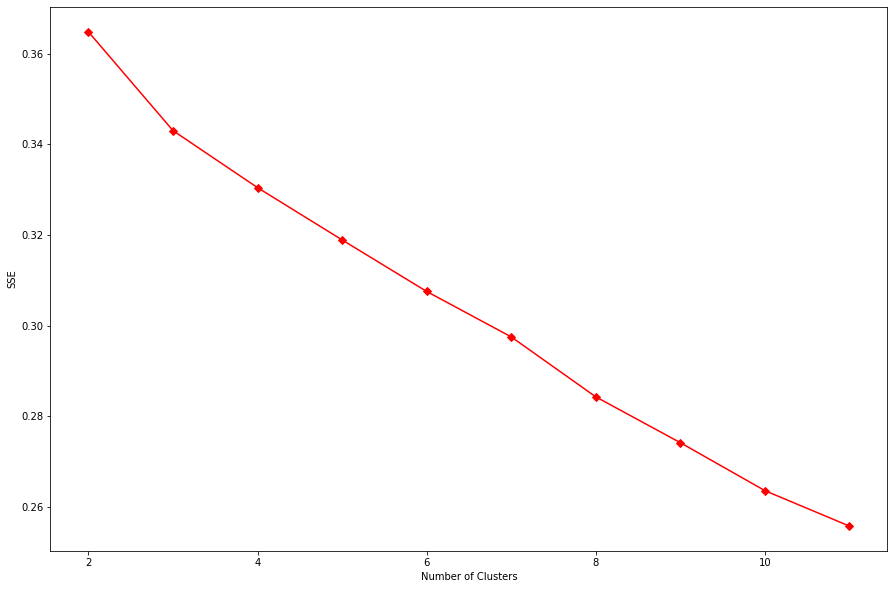

In [34]:
plt.figure(figsize=(15,10))
plt.plot(table.Cluster_Numbers, table.Error_Term, marker = "D", color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

- 엘보가 보이지 않음
- 이런 현상은 클러스터가 잘 정의되지 않은 데이터에서 매우 일반적
- 이는 엘보 기법의 단점이라고도 할 수 있지만, 데이터의 특성을 밝혀준다는 점에서 가치가 있음

In [35]:
# 종목 수를 고려해서 클러스터를 7개로 나눔
clusters = KMeans(7)
clusters.fit(final_df)
clusters.labels_

array([4, 5, 5, 5, 5, 6, 6, 6, 3, 1, 0, 5, 0, 5, 2, 4, 1, 6, 4, 1, 0, 6,
       6, 5, 6, 1, 2, 1, 0, 0, 1, 1, 0, 5, 0, 5, 5, 6, 6, 5, 0, 4, 4, 6,
       6, 4, 0, 6, 0, 0, 0, 1, 6, 0, 3, 1, 5, 0, 5], dtype=int32)

In [36]:
labels = clusters.predict(movements)
labels

array([4, 5, 5, 5, 5, 6, 6, 6, 3, 5, 0, 5, 5, 5, 2, 4, 5, 6, 5, 1, 0, 6,
       6, 5, 6, 1, 2, 1, 0, 0, 5, 1, 0, 5, 5, 5, 5, 6, 5, 5, 0, 4, 4, 6,
       6, 4, 5, 6, 5, 0, 0, 1, 6, 5, 3, 5, 5, 0, 5], dtype=int32)

In [37]:
print('labels : ',len(labels))
print('companies : ',len(companies))

labels :  59
companies :  59


In [38]:
print('security : ',len(security))
print('sector : ',len(sector))

security :  60
sector :  60


In [39]:
tickers.index("AMCR")

25

In [40]:
sector.pop(26)
security.pop(26)

'Ameren Corp'

In [41]:
clustered_result = pd.DataFrame({'labels': labels, 'tickers': companies, 'full-name':security, 'sector':sector})
clustered_result.sort_values('labels')

,labels,tickers,full-name,sector
29,0,AIG,American International Group,Financials
28,0,AXP,American Express,Financials
57,0,BKR,Baker Hughes,Energy
32,0,AMP,Ameriprise Financial,Financials
40,0,AON,Aon,Financials
10,0,AFL,Aflac,Financials
49,0,AIZ,Assurant,Financials
50,0,T,AT&T,Communication Services
20,0,ALL,Allstate Corp,Financials
19,1,LNT,Alliant Energy,Utilities


In [42]:
final_df['Cluster'] = clusters.labels_
final_df.head()

Date,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,2017-02-02 00:00:00,2017-02-03 00:00:00,2017-02-06 00:00:00,2017-02-07 00:00:00,2017-02-08 00:00:00,2017-02-09 00:00:00,2017-02-10 00:00:00,2017-02-13 00:00:00,2017-02-14 00:00:00,2017-02-15 00:00:00,2017-02-16 00:00:00,2017-02-17 00:00:00,2017-02-21 00:00:00,2017-02-22 00:00:00,2017-02-23 00:00:00,2017-02-24 00:00:00,2017-02-27 00:00:00,2017-02-28 00:00:00,2017-03-01 00:00:00,2017-03-02 00:00:00,...,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,Cluster
MMM,0.003951,-0.008914,0.007625,-0.014035,-0.010143,0.019331,-0.006592,-0.000734,-0.001910,0.018081,0.002774,-0.002771,0.000292,-0.037077,0.011254,0.001327,0.009726,-0.030245,-0.008913,0.005217,-0.014727,0.012866,0.000893,0.009822,0.019422,0.016335,0.011992,0.029406,0.008349,0.001435,0.024523,-0.006535,0.005982,0.037942,0.016107,0.003062,-0.006952,-0.007807,0.049081,0.000412,...,-0.022438,0.002482,-0.010504,0.039987,0.008223,-0.010498,0.006497,0.006481,-0.022844,0.017828,0.004895,-0.028163,-0.019755,-0.004245,0.006011,-0.036859,-0.149108,-0.056339,0.008203,-0.061732,-0.033997,0.010816,0.084351,0.008989,-0.044952,0.001139,0.037423,0.021654,-0.064269,0.020388,-0.034471,0.007544,-0.012756,-0.026787,-0.072728,-0.097363,0.037440,0.020992,-0.015965,4
ABT,0.023143,0.025183,0.079308,-0.002860,0.039357,-0.014827,-0.025548,0.015035,-0.002137,-0.009979,-0.025749,0.004330,-0.008647,-0.002168,0.000000,0.047010,0.002847,0.000711,0.054027,0.039085,0.028926,0.002046,-0.023851,0.031606,-0.033306,0.009626,0.013706,0.032741,0.029005,0.023376,0.013251,0.032319,0.020875,0.000000,0.025260,0.017980,-0.014040,-0.024369,0.032982,0.006395,...,-0.035540,0.015274,-0.016207,0.011884,0.007778,-0.036425,-0.008197,0.021235,0.055763,0.030027,0.023777,0.023912,0.069203,-0.035862,-0.010603,-0.026122,-0.001627,-0.013024,0.000654,-0.066049,-0.002676,0.039179,0.043946,-0.002930,-0.052135,0.014266,0.028724,-0.012424,-0.003612,0.032217,-0.025362,0.015744,-0.029362,-0.033286,-0.094010,-0.120567,0.008265,-0.077756,-0.079519,5
ABBV,0.028591,0.015378,0.000636,0.013350,-0.004421,-0.092727,0.004643,0.023493,-0.004252,-0.006556,-0.009208,-0.007598,-0.006300,-0.012640,0.026777,-0.003634,-0.042029,0.014532,0.022817,-0.007300,0.000000,-0.007326,-0.000668,-0.003009,-0.001339,0.010721,-0.013998,0.003020,0.010388,0.027671,-0.005591,0.009564,0.001970,-0.015413,0.019166,0.004910,0.004245,-0.012384,0.032461,0.013554,...,-0.019246,0.016002,-0.011567,0.014371,0.015629,-0.025849,-0.012294,-0.007330,0.024369,0.000000,-0.028622,-0.000230,-0.017974,-0.045105,-0.041138,0.011650,-0.006033,-0.013797,-0.034607,-0.018843,0.032034,0.050753,0.054561,0.012873,0.118850,0.054047,0.026750,0.037807,-0.050593,-0.027645,-0.009486,0.011480,0.001938,0.015708,-0.038862,-0.086209,-0.017507,-0.068575,0.006884,5
ABMD,0.039471,-0.010543,0.006972,0.019213,-0.054565,-0.011340,0.012972,0.038534,-0.018717,-0.008631,-0.012279,-0.004327,-0.003168,0

In [43]:
final_df.tail()

Date,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,2017-02-02 00:00:00,2017-02-03 00:00:00,2017-02-06 00:00:00,2017-02-07 00:00:00,2017-02-08 00:00:00,2017-02-09 00:00:00,2017-02-10 00:00:00,2017-02-13 00:00:00,2017-02-14 00:00:00,2017-02-15 00:00:00,2017-02-16 00:00:00,2017-02-17 00:00:00,2017-02-21 00:00:00,2017-02-22 00:00:00,2017-02-23 00:00:00,2017-02-24 00:00:00,2017-02-27 00:00:00,2017-02-28 00:00:00,2017-03-01 00:00:00,2017-03-02 00:00:00,...,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,Cluster
AZO,0.004522,-0.002971,0.002603,-0.007343,0.009574,-0.004795,-0.004948,-0.029985,0.007205,-0.011554,-0.024450,0.000353,-0.090231,-0.002819,-0.010523,-0.015750,0.000341,-0.017347,0.001783,-0.031216,0.033078,-0.002217,-0.013222,0.003679,0.060899,0.014918,-0.016066,-0.013947,-0.000923,0.011423,-0.006556,0.011337,-0.001192,-0.016302,-0.024985,0.017227,0.025042,-0.013149,0.007443,-0.016677,...,-0.003351,-0.042467,-0.039508,0.004173,-0.004146,-0.026048,-0.007703,0.016523,-0.004604,0.015638,0.024714,0.000824,0.004570,0.016971,-0.050068,-0.051140,-0.014046,-0.022642,-0.020515,-0.059669,-0.016081,-0.000518,0.049699,-0.023092,-0.007251,-0.011103,-0.005375,0.026614,0.006347,-0.028335,0.044395,-0.014894,0.033404,-0.030323,-0.024159,-0.051348,-0.040868,-0.020285,0.062057,3
AVB,0.014809,0.021819,0.031526,-0.055337,-0.008087,-0.033435,0.029045,-0.006696,0.001016,0.005284,-0.027394,0.035785,-0.001417,-0.027141,-0.043471,0.016114,-0.022418,-0.020903,0.024981,-0.076493,0.125270,-0.041026,0.026635,0.018446,0.056685,-0.005018,0.032563,-0.026294,-0.001806,-0.012649,0.024984,-0.010605,0.051375,-0.007716,0.040447,0.006078,0.008416,0.005663,-0.009163,-0.009187,...,0.034405,0.005994,-0.077958,0.014855,0.008354,0.036463,0.044175,-0.025639,0.040873,0.050557,0.019675,0.053561,-0.043460,0.030597,0.013775,-0.007678,0.006712,-0.043302,0.022991,-0.021694,0.000000,0.034393,-0.018998,0.025027,0.000654,0.042178,0.018258,0.024274,0.019161,0.030812,0.008504,-0.035662,0.021422,0.013723,-0.035041,-0.069504,-0.003075,-0.219461,-0.122153,1
AVY,0.074166,-0.025599,0.035321,0.005748,0.006094,-0.001073,-0.020393,0.000721,0.010815,0.025848,-0.024172,-0.002870,0.017242,0.033543,0.023251,-0.040155,0.015250,-0.030322,0.003924,0.236163,0.011756,-0.031208,0.015135,-0.012104,0.008874,-0.016705,0.012197,0.005906,-0.005238,0.008201,0.020274,-0.024336,0.030789,-0.017480,0.027375,-0.012900,0.014585,0.000322,0.036738,-0.002542,...,-0.016092,-0.032788,-0.005739,0.007806,0.035638,-0.004445,0.049385,0.011520,0.008503,0.039224,0.014952,-0.081088,-0.005779,0.011784,-0.022666,-0.036905,0.027874,0.141312,-0.002291,-0.093063,0.054303,0.055716,0.061960,-0.022648,-0.049627,0.007637,0.018655,0.041769,-0.031064,-0.000565,-0.040485,0.015111,0.000000,-0.053629,-0.126603,-0.120630,-0.035958,-0.103093,-0.013560,5
BKR,-0.007891,-0.010700,-0.011163,-0.020060,-0.024345,0.028795,-0.027124,-0.042752,0.028638,-0.004560,0.006233,0.000828,-

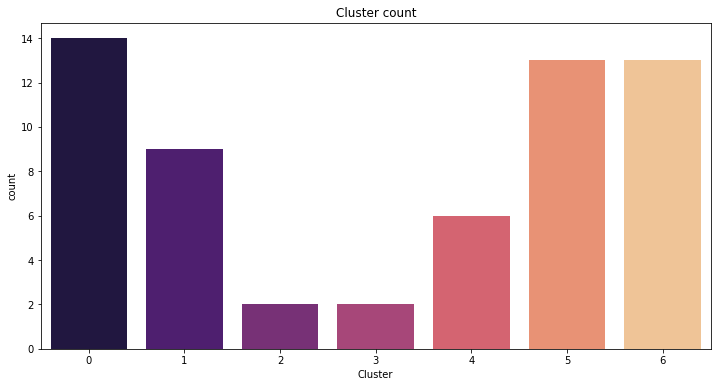

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'Cluster', data = final_df, palette = 'magma')
plt.title('Cluster count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)